In [220]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [ ]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function


In [222]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []

def flip_horizontal(image):
    flipped = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            flipped[i, j] = image[i, image.shape[1] - 1 - j]
    return flipped

def rotate(image):
    rotated = np.zeros((image.shape[1], image.shape[0]), dtype=image.dtype)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rotated[j, image.shape[0] - 1 - i] = image[i, j]
    return rotated

for i in range(len(data)):
    flipped = flip_horizontal(data[i])
    rotated = rotate(data[i])

    data_augmented.append(flipped)
    data_augmented.append(rotated)

    labels_augmented.extend([labels[i]] * 2)
    file_name_augmented.extend([file_name[i] + '_flip', file_name[i] + '_rot'])


In [223]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  144
Data setelah augmentasi:  288


## Data Preparation

### Define Preprocessing Function


In [224]:
def resize(image, new_width, new_height):
    old_height, old_width = image.shape[:2]
    resized_image = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = int(j * old_width / new_width)
            y = int(i * old_height / new_height)
            resized_image[i, j] = image[y, x]

    return resized_image

def equalization(image):
    frequent = {}
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            value = image[i, j]
            if value in frequent:
                frequent[value] += 1
            else:
                frequent[value] = 1

    cumuFreq = {}
    sortedKey = sorted(frequent.keys())
    
    total = 0
    for key in sortedKey:
        total += frequent[key]
        cumuFreq[key] = total

    newPixel = {}
    sumAllPixel = image.shape[0] * image.shape[1]
    for key in sortedKey:
        newPixel[key] = round((cumuFreq[key] / sumAllPixel) * 255)

    newImage = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            newImage[i, j] = newPixel[image[i, j]]

    return newImage
    
def sobel(gray):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[ 1,  2,  1],
                        [ 0,  0,  0],
                        [-1, -2, -1]])

    tinggi, lebar = gray.shape
    hasil = np.zeros((tinggi, lebar), dtype=np.float32)

    for i in range(1, tinggi-1):
        for j in range(1, lebar-1):
            region = gray[i-1:i+2, j-1:j+2]
            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)
            hasil[i, j] = np.sqrt(gx**2 + gy**2)

    hasil = np.clip(hasil, 0, 255)
    return hasil.astype(np.uint8)


### Preprocessing

In [225]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)):
    img = resize(data[i], 128, 128)
    img = equalization(img)
    dataPreprocessed.append(img)


### Feature Extraction

In [226]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [227]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [228]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [229]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [230]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [231]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [232]:
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]

In [233]:
def entropyGlcm(matrix):
    glcm_array = matrix[:, :, 0, 0]
    return entropy(glcm_array.flatten())


In [234]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [235]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [236]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [237]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [238]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [239]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [240]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [241]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [242]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [243]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,08-11-2022-09-29-23_jpg.rf.64d249dc62a73d0ad8a...,fresh,1616.116203,1916.209994,808.903113,1831.422469,0.090092,0.082204,0.161575,0.081287,...,0.000373,0.000171,0.013630,0.013177,0.019313,0.013076,0.849934,0.821293,0.925110,0.829211
1,08-11-2022-09-31-38_jpg.rf.a062a431d30171b3151...,fresh,1874.887795,2179.164734,828.220657,2039.071300,0.081686,0.070786,0.137295,0.075211,...,0.000229,0.000123,0.011301,0.010711,0.015117,0.011091,0.826640,0.797767,0.923312,0.810762
2,08-11-2022-09-33-12_jpg.rf.b59993e6f78e188270c...,fresh,1849.459092,2130.288425,764.333600,1955.493149,0.081101,0.070545,0.141227,0.077402,...,0.000251,0.000124,0.011293,0.010873,0.015854,0.011136,0.828884,0.802610,0.929268,0.818805
3,08-11-2022-09-33-46_jpg.rf.ac147752030f7341361...,fresh,1090.452202,1502.595015,1071.820866,1653.601587,0.121909,0.094325,0.118711,0.088430,...,0.000442,0.000346,0.022129,0.018928,0.021013,0.018606,0.899094,0.860441,0.900923,0.846415
4,08-11-2022-09-38-25_jpg.rf.98422f41a439f4b9caf...,fresh,1537.267409,1687.991196,494.634658,1560.505673,0.087720,0.080373,0.153266,0.082433,...,0.000321,0.000159,0.012702,0.012318,0.017922,0.012599,0.858142,0.843867,0.954243,0.855657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,08-11-2022-22-04-53_jpg.rf.898d4dacb6b481c54a1...,spoiled,727.897945,1174.200880,759.850886,1114.623907,0.135792,0.099495,0.133111,0.104832,...,0.000538,0.000444,0.024151,0.020646,0.023191,0.021073,0.932459,0.891037,0.929906,0.896566
140,08-11-2022-22-05-41_jpg.rf.1911a77bc56f9cf0c0d...,spoiled,1304.683501,1379.134540,276.792569,1356.788828,0.108790,0.098683,0.169103,0.092816,...,0.000537,0.000278,0.017409,0.016901,0.023167,0.016660,0.879492,0.872418,0.974357,0.874494
141,08-11-2022-22-06-09_jpg.rf.22c8c2df12f95b3ce32...,spoiled,1388.272884,1557.044268,425.759473,1482.988468,0.098801,0.091829,0.148540,0.086013,...,0.000306,0.000162,0.013320,0.012832,0.017496,0.012731,0.871986,0.856005,0.960577,0.862865
142,08-11-2022-22-06-15_jpg.rf.a281f03d8553c96d251...,spoiled,1485.818098,1684.257363,480.287832,1582.006014,0.100983,0.090522,0.139226,0.083942,...,0.000291,0.000154,0.012981,0.012313,0.017050,0.012428,0.862997,0.844236,0.955535,0.853704


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

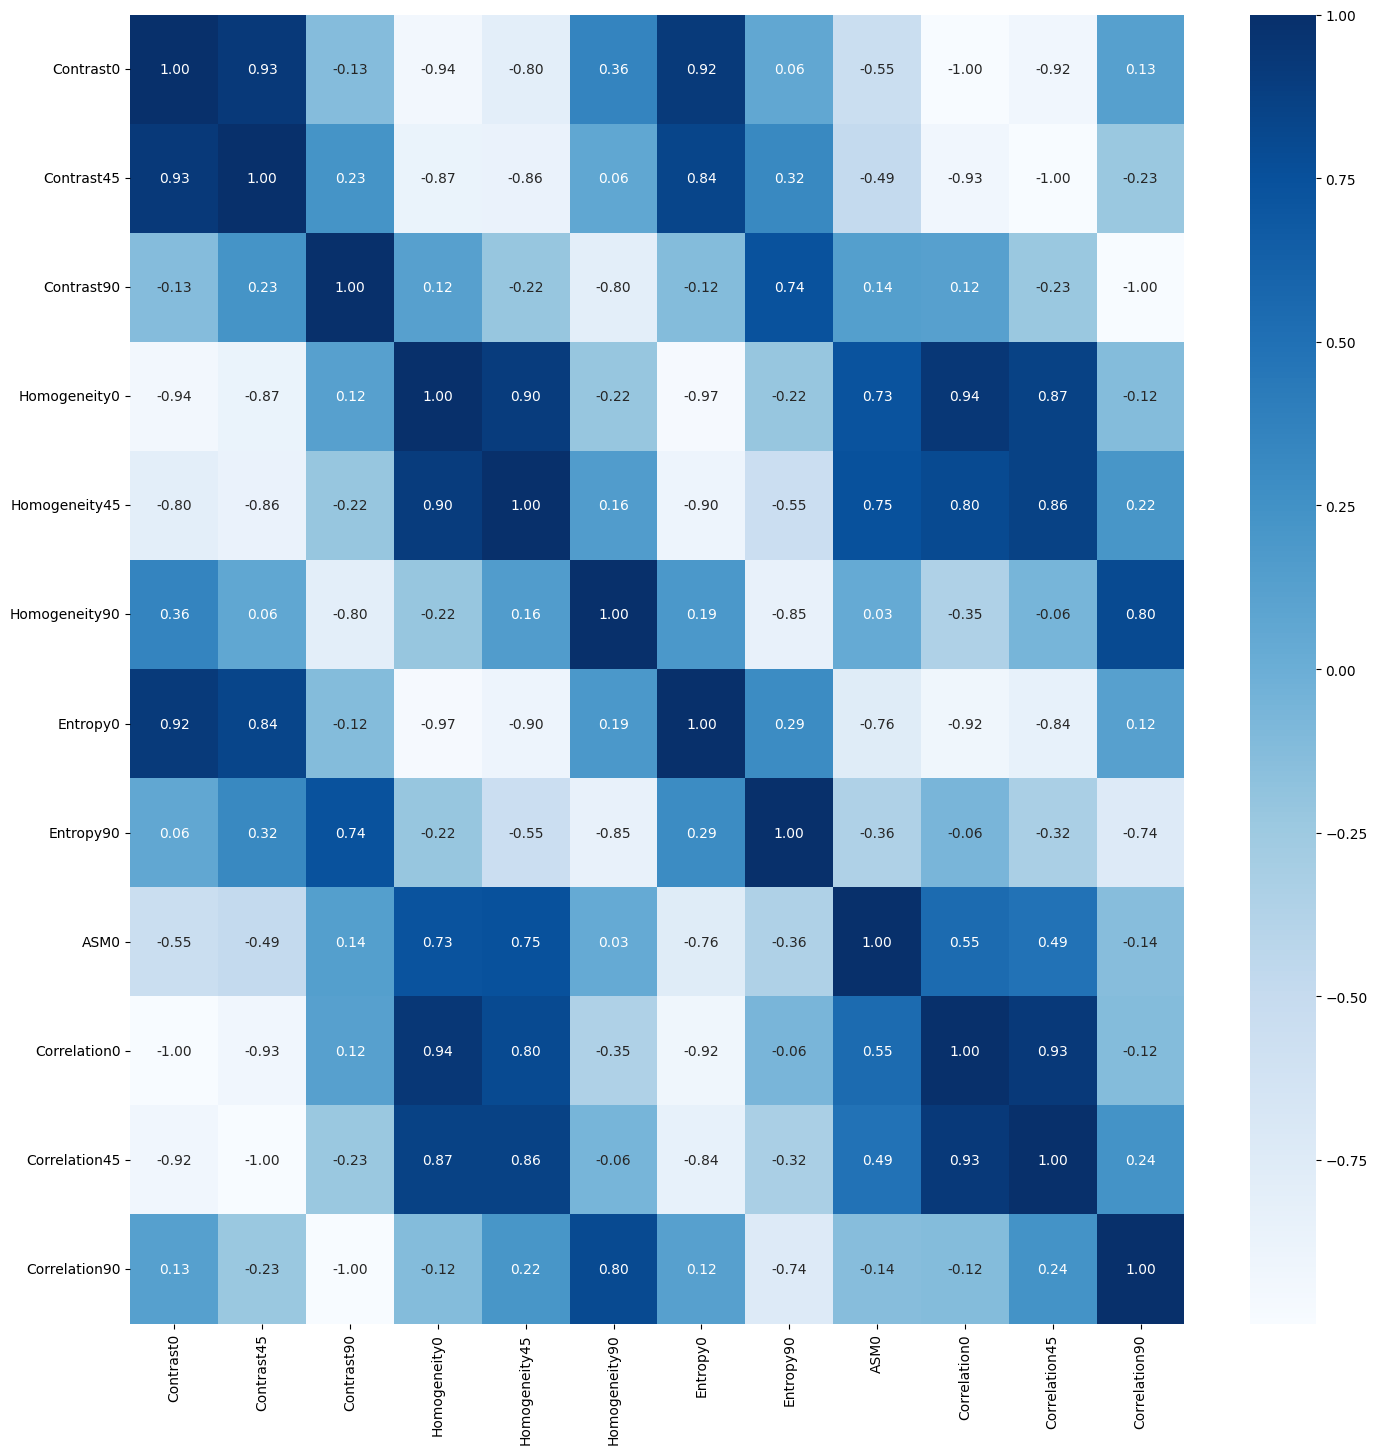

In [244]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [245]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(115, 12)
(29, 12)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [246]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [247]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [248]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       fresh       1.00      0.98      0.99        56
     spoiled       0.98      1.00      0.99        59

    accuracy                           0.99       115
   macro avg       0.99      0.99      0.99       115
weighted avg       0.99      0.99      0.99       115

[[55  1]
 [ 0 59]]
Accuracy: 0.991304347826087

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.81      0.90        16
     spoiled       0.81      1.00      0.90        13

    accuracy                           0.90        29
   macro avg       0.91      0.91      0.90        29
weighted avg       0.92      0.90      0.90        29

[[13  3]
 [ 0 13]]
Accuracy: 0.896551724137931


### Train SVM Classifier

In [249]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       fresh       0.92      0.88      0.90        56
     spoiled       0.89      0.93      0.91        59

    accuracy                           0.90       115
   macro avg       0.91      0.90      0.90       115
weighted avg       0.91      0.90      0.90       115

[[49  7]
 [ 4 55]]
Accuracy: 0.9043478260869565

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.81      0.90        16
     spoiled       0.81      1.00      0.90        13

    accuracy                           0.90        29
   macro avg       0.91      0.91      0.90        29
weighted avg       0.92      0.90      0.90        29

[[13  3]
 [ 0 13]]
Accuracy: 0.896551724137931


### Train KNN Classifier

In [250]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       fresh       0.96      0.89      0.93        56
     spoiled       0.90      0.97      0.93        59

    accuracy                           0.93       115
   macro avg       0.93      0.93      0.93       115
weighted avg       0.93      0.93      0.93       115

[[50  6]
 [ 2 57]]
Accuracy: 0.9304347826086956

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.69      0.81        16
     spoiled       0.72      1.00      0.84        13

    accuracy                           0.83        29
   macro avg       0.86      0.84      0.83        29
weighted avg       0.88      0.83      0.83        29

[[11  5]
 [ 0 13]]
Accuracy: 0.8275862068965517


## Evaluation With Confusion Matrix

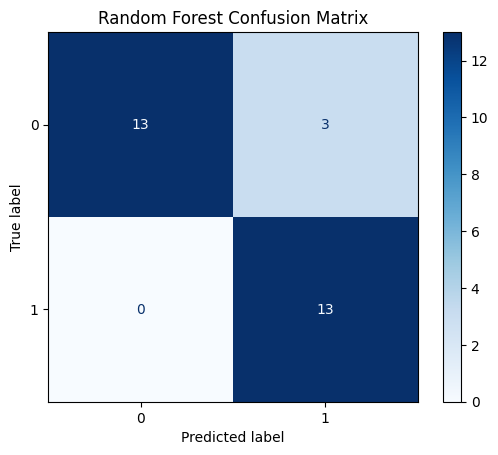

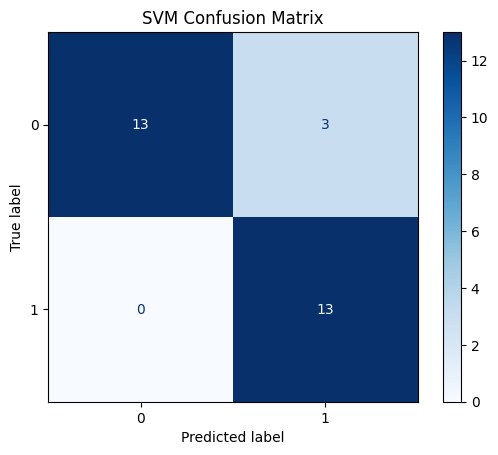

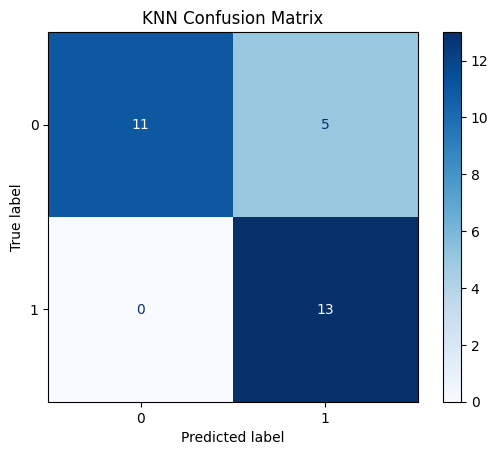

In [251]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")